In [1]:
!pip install tensorflow

import tensorflow as tf
# Checking the version of tensorflow
print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


2024-08-10 15:47:25.668361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 15:47:25.668476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 15:47:25.789523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [2]:
# Import necessary libraries
from tensorflow.keras.layers import Input ,Dense , Dropout , BatchNormalization , LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys , os 


In [3]:
#  Loading the handwritten didgits dataset MNIST
mnist = tf.keras.datasets.mnist

(X_train , y_train) ,  (X_test,y_test) = mnist.load_data()

# Scaling the images between -1 to 1 as all the images ranges(0-255)
X_train = X_train/255 * 2 -1
X_test = X_test/255 * 2 - 1

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Printing the shape of X_train , X_test , y_train and y_test
print(f'X_train is: {X_train.shape}')
print(f'X_test is:  {X_test.shape}')
print(f'y_train is: {y_train.shape}')
print(f'y_test is: {y_test.shape}')

X_train is: (60000, 28, 28)
X_test is:  (10000, 28, 28)
y_train is: (60000,)
y_test is: (10000,)


In [5]:
# Reshaping the training and testing images to 2-D dimension (flattening images)

M,H , W = X_train.shape
D = H * W
X_train = X_train.reshape(-1,D)
X_test = X_test.reshape(-1,D)

In [6]:
print(f'X_train is: {X_train.shape}')
print(f'X_test is:  {X_test.shape}')

X_train is: (60000, 784)
X_test is:  (10000, 784)


In [7]:
# Now we define the latent_dim to generate the noises for the generator
latent_dim = 100

In [8]:
# Generating the generator
def build_generator(latent_dim):
    i = Input(latent_dim,)
    x = Dense(256,activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512,activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D,activation='tanh')(x)
    
    model = Model(i,x)
    return model

In [9]:
# Building the discriminator for the network
def build_discriminator(img_size):
    i = Input(img_size,)
    x = Dense(512,activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256,activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1,activation='sigmoid')(x)
    
    model = Model(i,x)
    return model
  
    

In [10]:
# Build discriminator and compiling
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5) , metrics=['accuracy'])

# building generator we are not compiling it because we have to train it on different images
generator = build_generator(latent_dim)

In [11]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 1024)              5253

In [13]:
# we don't need to train our discriminator 
discriminator.trainable = False

In [14]:
# Creating an image from noise
z = Input(latent_dim,)
print(z.shape)

(None, 100)


In [15]:
img = generator(z)
print(img.shape)

(None, 784)


In [16]:
#  Passing the generator generated image to discriminator
fake_pred = discriminator(img)
print(fake_pred.shape)

(None, 1)


In [17]:
combined_model_gen = Model(z,fake_pred)

In [18]:
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [19]:
# Config the parameters
batch_size = 32
epochs = 30000
sample_period = 200 

In [20]:
# Store the losses 
g_losses = []
d_losses = []



In [21]:
# Make the directoru=y to store generated images
if not os.path.exists("generated_images"):
    os.makedirs('generated_images')

In [22]:
def sample_images(epoch):
    rows , columns = 4 ,4
    noise = np.random.rand(rows * columns , latent_dim)
    images = generator.predict(noise , verbose = 0)
    
    fig, axs = plt.subplots(rows, columns)
    idx = 0
    for i in range(rows):
        for j in range(columns):
            axs[i,j].imshow(images[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig(f'generated_images/{epoch}.png')
    plt.close()
     

In [23]:
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

In [24]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf


In [25]:
# Training loop
for epoch in range(epochs):
    ###########################
    ### Train discriminator ###
    ###########################
    
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_imgs = X_train[idx] 
    
    
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise , verbose=0)
    
    # Train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones ,)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
    
    
    #######################
    ### Train generator ###
    #######################
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)
    
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)
    
    
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 10000 == 0:
        print(f"epoch: {epoch}/{epochs}, d_loss: {d_loss:.2f}, \ d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
    if epoch % sample_period == 0:
        sample_images(epoch)


I0000 00:00:1723304860.677674     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch: 0/30000, d_loss: 0.79, \ d_acc: 0.36, g_loss: 0.60
epoch: 10000/30000, d_loss: 0.66, \ d_acc: 0.61, g_loss: 0.81
epoch: 20000/30000, d_loss: 0.73, \ d_acc: 0.53, g_loss: 0.83


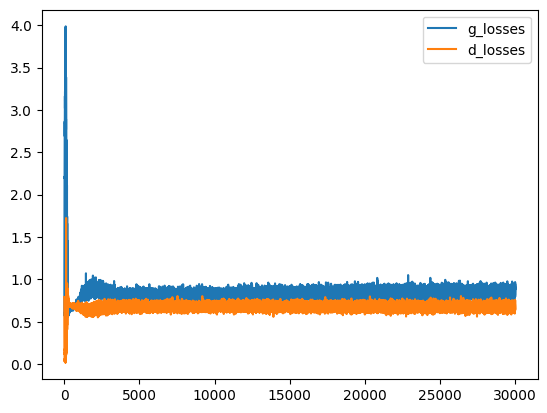

In [31]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses , label = 'd_losses')
plt.legend()

In [32]:
!ls generated_images

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
1000.png   1400.png   1800.png	 21800.png  25800.png  29800.png  6800.png
10000.png  14000.png  18000.png  2200.png   2600.png   3000.png   7000.png
10200.png  14200.png  18200.png  22000.png  26000.png  3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  400.png	  800.png
11200.png  15200.png  19200.png  23000.png  27000.png  4000.png   8000.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
1200.png   1600.png   200.png	 23800.png  27800.png  4800.png   8800.png
12000.png  16000.png  2000.png	 

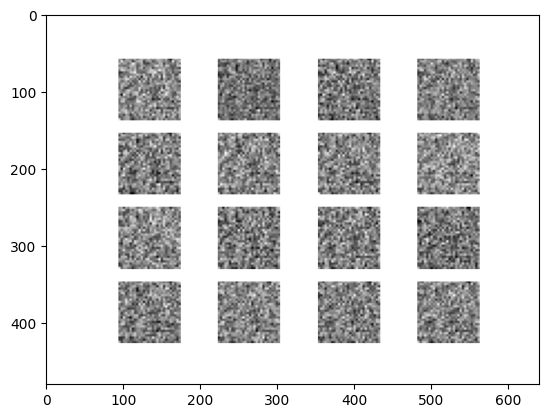

In [33]:
from skimage.io import imread
a = imread('generated_images/0.png')
plt.imshow(a)

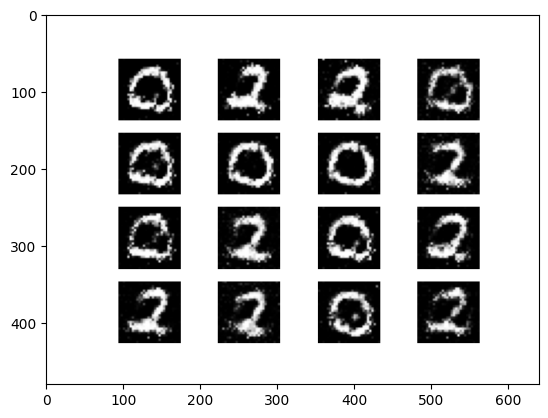

In [34]:
a = imread('generated_images/10000.png')
plt.imshow(a)

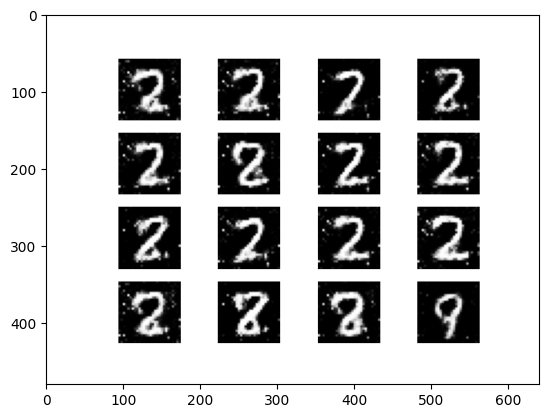

In [35]:
a = imread('generated_images/20000.png')
plt.imshow(a)

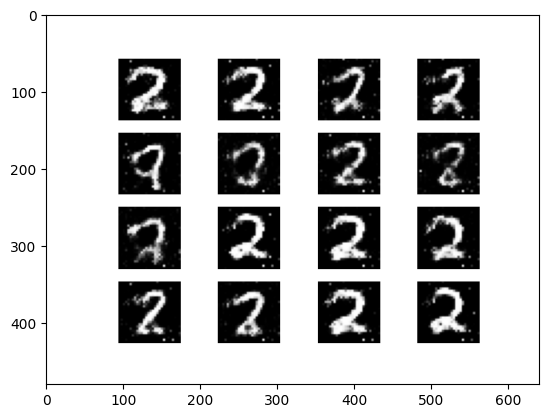

In [36]:
a = imread('generated_images/29800.png')
plt.imshow(a)